In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)

In [3]:
def string_day_nomber(day):
    return (str(int (day/100)%10) +
            str(int (day/10)%10) +
            str(int (day/1)%10))

def create_mining_stuff(path):
    ret = []
    for i in range(124):
        ret.append(torch.load(path + string_day_nomber(i)))
    return ret


In [4]:
injection = torch.load("Data/injection1div7")
mining_coordinates = create_mining_stuff("Data/NEW_mining_int_coordinates_1div7/input_tensor_int")
mining_resources   = create_mining_stuff("Data/NEW_mining_output_1div7_normalize/output_tensor")

injection_train = injection[0:105]
mining_coordinates_train = mining_coordinates[0:105]
mining_resources_train = mining_resources[0:105]

injection_test = injection[105:124]
mining_coordinates_test = mining_coordinates[105:124]
mining_resources_test = mining_resources[105:124]


# for elem in mining_resources:
#     elem = torch.log(elem)

In [5]:
N_FEATURES_INJECTION = injection.shape[1]
N_CELLS_HOR = injection.shape[2]
N_CELLS_VER = injection.shape[3]

### Model itself

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        
        self.CONV  = nn.Conv2d    (in_channels,
                                   out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   bias=False)             # think about it later
        
        self.BNORM =nn.BatchNorm2d(out_channels,
                                   eps=1e-05,
                                   momentum=0.1,
                                   affine=False)
#         self.RELU  = nn.ReLU ()
        
#         self.MAXPOOL = nn.MaxPool2d(3,
#                                     stride=1,
#                                     padding=1,
#                                     dilation=1)
        
    def forward(self, x):
        #print ('sizeof(x) = ', x.size())
        #print ('sizeof(xprev) = ', xprev.size())    
        
        x = self.CONV   (x)
        x = self.BNORM  (x)
#         x = self.RELU   (x)
#         x = self.MAXPOOL(x)
        
        return x

In [7]:
class MapToAmount (nn.Module):
    def __init__(self, kernel_radius=1):
        super(MapToAmount, self).__init__()
        
        self.n_features = int(2 * kernel_radius - 1) ** 2
        self.linear = nn.Linear(self.n_features, 1)
        
    def forward(self, mapa):
#         print (mapa.shape)
#         print (self.n_features)
#         print (mapa.view(self.n_features).shape)
        return self.linear(mapa.view(self.n_features))  

In [8]:
class LSTMCell (nn.Module):
    
    def __init__ (self,
                  n_features_in,
                  n_features_out,
                  embedding_size=16,
                  hidden_state_size=16,
                  output_lin_radius=1):
        super(self.__class__,self).__init__()
        
        self.out_rad  = output_lin_radius
        self.emb_size = embedding_size
        self.hid_size = hidden_state_size
        
#         self.embedding = ConvBlock (1, self.emb_size, kernel_size=3)
        self.embedding = nn.Sequential(ConvBlock(n_features_in,
                                                 self.emb_size,
                                                 3),
                                       nn.ReLU(),
                                       ConvBlock(self.emb_size,
                                                 self.emb_size,
                                                 3))
        
        self.f_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        self.i_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        self.c_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Tanh())
        self.o_t = nn.Sequential (ConvBlock(self.hid_size + self.emb_size,
                                            self.hid_size,
                                            3),
                                  nn.Sigmoid())
        
        
        #===========Output stuff============================================
        self.hidden_to_result = nn.Sequential (ConvBlock (hidden_state_size, 
                                                          hidden_state_size, 
                                                          kernel_size=3),
                                               nn.ReLU   (),
                                               # TODO BatchNorm
                                               ConvBlock (hidden_state_size,
                                                          n_features_out,
                                                          kernel_size=3,
                                                          padding=4))
        
        self.  oil_result = MapToAmount(kernel_radius=output_lin_radius)
        self.water_result = MapToAmount(kernel_radius=output_lin_radius)
        self.  gas_result = MapToAmount(kernel_radius=output_lin_radius)
        
        
    def forward (self, x, prev_state, holes_coordinates):
        (prev_c, prev_h) = prev_state
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([prev_h, x_emb], dim=1)
        
        f_i = self.f_t(x_and_h)
        i_i = self.i_t(x_and_h)
        c_i = self.c_t(x_and_h)
        o_i = self.o_t(x_and_h)
        
        next_c = prev_c * f_i + i_i * c_i
        next_h = torch.tanh(next_c) * o_i
        
        assert prev_h.shape == next_h.shape
        assert prev_c.shape == next_c.shape
        
        res_map = self.hidden_to_result(next_h)
        res = torch.zeros(holes_coordinates.shape[0], 3, device=DEVICE)
        for i in range(holes_coordinates.shape[0]):
            x = holes_coordinates[i, 0].item()
            y = holes_coordinates[i, 1].item()
            loc_map = (torch.zeros(2*self.out_rad - 1, 2*self.out_rad - 1, device=DEVICE) +
                       res_map[0, :, 
                              (x - self.out_rad + 1 + 3):(x + self.out_rad + 3),
                              (y - self.out_rad + 1 + 3):(y + self.out_rad + 3)])
#             print ("x and y", x, y)
#             print (res_map.shape)
            res[i, 0] = self.  oil_result(loc_map[0])
            res[i, 1] = self.water_result(loc_map[1])
            res[i, 2] = self.  gas_result(loc_map[2])
            
            
        
        return (next_c, next_h), res
        
    def init_state (self, batch_size, device=torch.device("cpu")):
        return (Variable(torch.ones(batch_size,
                                     self.hid_size,
                                     N_CELLS_HOR,
                                     N_CELLS_VER,
                                     device=device)),
                Variable(torch.ones(batch_size,
                                     self.hid_size,
                                     N_CELLS_HOR,
                                     N_CELLS_VER,
                                     device=device)))
               
    

In [9]:
def train_network_RNN (RNN_cell,
                       device,
                       injection,
                       mining_coordinates,
                       mining_resources,
                       n_cycles=1,
                       learning_rate=0.0003,
                       lr_decay=1.):
    
    loss_massive = []
    
    RNN_cell.to(device)
    
#     weights = torch.tensor([1., earthquake_weight], dtype=torch.float).to(device)
    criterion = nn.MSELoss().to(device)
    
    i = 0
    hid_state = RNN_cell.init_state(batch_size=1, device=device)
        
    for cycle in range(n_cycles):
        
#         for elem in RNN_cell.parameters():
#             print (type(elem))
#             print (elem.shape)
        optimizer = torch.optim.Adam(RNN_cell.parameters(), lr=learning_rate)
        optimizer.zero_grad()
        
#         hid_state = RNN_cell.init_state(batch_size=1, device=device)
        
        
        for t in range(injection.shape[0]):
            
            inputs      = injection[t].unsqueeze(0).to(device)
            coordinates = mining_coordinates[t].to(device)
            target      = mining_resources  [t].to(device)
            
#             print ("inputs", inputs.shape)
#             print ("hid_state", hid_state)
#             print ("coordinates", coordinates.shape)
#             print ("target", target.shape)
            
            hid_state, outputs = RNN_cell.forward(inputs, hid_state, mining_coordinates[t])
            
#             print ("outputs device :", outputs.device, outputs.shape)
#             print ("target  device :", target .device, target .shape)
            
            loss = criterion(outputs, target)
#             print (outputs)
#             print(target)
#             print (loss)
#             print ("==================")
            loss_massive.append(loss.item())
            loss.backward(retain_graph=True)
#             print (t, RNN_cell.f_t[0].CONV.weight.grad[1, 1, 1, 1].item(),
#                       RNN_cell.i_t[0].CONV.weight.grad[2, 2, 2, 2].item(),
#                       RNN_cell.o_t[0].CONV.weight.grad[3, 3, 2, 2].item())
#             loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
#             print (t, RNN_cell.f_t[0].CONV.weight[1, 1, 1, 1].item(),
#                    RNN_cell.i_t[0].CONV.weight[2, 2, 2, 2].item(),
#                    RNN_cell.o_t[0].CONV.weight[3, 3, 2, 2].item())
    
            
#             print ("day : ", i, "loss : ", loss.item())
            
#             if (type(hid_state) == tuple):
#                 for elem in hid_state:
#                     elem.detach_()
#             else:
#                 hid_state.detach_()
            
            if (i)%5==0:
                clear_output(True)
                print ("Done :", i, "/", n_cycles*injection.shape[0])
                plt.plot(loss_massive,label='loss')
                plt.legend()
                plt.show()
            i += 1
        learning_rate /= lr_decay
    return hid_state
         

Done : 120 / 124


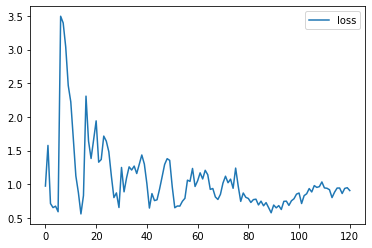

torch.Size([1, 16, 50, 50]) torch.Size([1, 16, 50, 50])


In [10]:
RNN_model = LSTMCell(N_FEATURES_INJECTION,
                     3,
                     embedding_size=16,
                     hidden_state_size=16,
                     output_lin_radius=4)

last_hid_state = train_network_RNN(RNN_model,
                                   DEVICE,
                                   injection,
                                   mining_coordinates,
                                   mining_resources,
                                   n_cycles=1,
                                   learning_rate=0.003,
                                   lr_decay=1.0)
print (last_hid_state[0].shape,
       last_hid_state[1].shape)

In [11]:
def predict_values (RNN_cell,
                    hid_state,
                    device,
                    injection,
                    mining_coordinates):
    
    RNN_cell.eval().to(device)
    for elem in hid_state:
        elem.to(device)

    i = 0
        
    # hid_state = RNN_cell.init_state(batch_size=1, device=device)
        
    prediction_massive = []
    for t in tqdm(range(injection.shape[0])):

        inputs      = injection[t].unsqueeze(0).to(device)
        coordinates = mining_coordinates[t].to(device)

        hid_state, prediction = RNN_cell.forward(inputs, hid_state, mining_coordinates[t])
        prediction_massive.append(prediction)
        
    return prediction_massive

In [12]:
# predict_massive = predict_values(RNN_model,
#                                  last_hid_state,
#                                  DEVICE,
#                                  injection_test,
#                                  mining_coordinates_test)

In [13]:
def compare_pred_and_target(prediction,
                            target,
                            device):
    MSE_massive = []
    MAE_massive = []
    assert len(prediction) == len(target)
    
    criterionMSE = nn.MSELoss()
    criterionMAE = nn.L1Loss()
    
    for t in range(len(prediction)):
        MSE_massive.append(criterionMSE(prediction[t].to(device),
                                        target[t]    .to(device)).item())
        MAE_massive.append(criterionMAE(prediction[t].to(device),
                                        target[t]    .to(device)).item())
    return MSE_massive, MAE_massive
        
        
    

In [14]:
# MSE_massive, MAE_massive = compare_pred_and_target(predict_massive,
#                                                    mining_resources_test,
#                                                    DEVICE)

In [15]:
# mean_MSE = 0
# mean_MAE = 0
# for i in range(len(MSE_massive)):
#     mean_MSE += MSE_massive[i]
#     mean_MAE += MAE_massive[i]
# mean_MSE /= len(MSE_massive)
# mean_MAE /= len(MAE_massive)


In [16]:
# print ("mean MSE :", mean_MSE)
# print ("mean MAE :", mean_MAE)

In [17]:
def save_model_state(model, state):
    torch.save(model.to('cpu').state_dict(), "model_state/state_dict")
    torch.save(state[0].to('cpu')          , "model_state/state_0")
    torch.save(state[1].to('cpu')          , "model_state/state_1")

def load_model_state():
    state=[]
    model = LSTMCell(N_FEATURES_INJECTION,
                     3,
                     embedding_size=16,
                     hidden_state_size=16,
                     output_lin_radius=4)
    model.load_state_dict(torch.load("model_state/state_dict"))
    state.append(torch.load("model_state/state_0"))
    state.append(torch.load("model_state/state_1"))
    return model, state
    

In [18]:
save_model_state(RNN_model,
                 last_hid_state)

In [24]:
model, state = load_model_state()
print (model.state_dict().device)

AttributeError: 'collections.OrderedDict' object has no attribute 'device'

In [20]:
# A = torch.ones(2, 2)
# B = torch.zeros(A.shape) + A
# B -= 1
# print (A)
# print(B)